### Code to run 5 different doublet removal methods at once

In [1]:
import scanpy as sc
import scanpy.external as sce
import doubletdetection

import scvi

import pandas as pd



import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython


/tmp/ipykernel_90902/2436057243.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R
library(scds)
library(SingleCellExperiment)
library(Seurat)
library(DoubletFinder)


do_scds <- function(data, genes, cells){
    # Ensure correct sparse format for the count matrix
    data <- as(data, "sparseMatrix")

    rownames(data) <- genes
    colnames(data) <- cells

    sce <- SingleCellExperiment(assays = list(counts = data))
    
    sce <- cxds_bcds_hybrid(sce, estNdbl = TRUE)

    #sce <- bcds(sce, retRes = TRUE)


    out <- colData(sce)$hybrid_call
    
    # Return the array of doublet annotations
    return(out)
}


do_df <- function(data, genes, cells){
    # Ensure correct sparse format for the count matrix
    data <- as(data, "sparseMatrix")

    rownames(data) <- genes
    colnames(data) <- cells

    seurat_obj <- CreateSeuratObject(counts = data)
    
    seurat_obj <- NormalizeData(seurat_obj)
    seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
    seurat_obj <- ScaleData(seurat_obj)
    seurat_obj <- RunPCA(seurat_obj)
    seurat_obj <- FindNeighbors(seurat_obj, dims = 1:10)
    seurat_obj <- FindClusters(seurat_obj, resolution = 0.5)

    ## pK Identification (no ground-truth)
    sweep.res.list <- paramSweep(seurat_obj, PCs = 1:10, sct = FALSE)
    sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
    bcmvn <- find.pK(sweep.stats)

    ## Optimal pK value
    optimal_pK <- as.numeric(as.character(bcmvn$pK[which.max(bcmvn$BCmetric)]))

    ## Homotypic Doublet Proportion Estimate
    homotypic.prop <- modelHomotypic(seurat_obj$seurat_clusters)

    ## Number of expected doublets (adjust based on your expected rate)
    nExp_poi <- round(0.1 * ncol(seurat_obj))  # Assuming 10% doublet rate
    nExp_poi.adj <- round(nExp_poi * (1 - homotypic.prop))

    ## Run DoubletFinder with adjusted parameters
    seurat_obj <- doubletFinder(seurat_obj,
                                   PCs = 1:10,
                                   pN = 0.25,
                                   pK = optimal_pK,
                                   nExp = nExp_poi.adj,
                                   reuse.pANN = FALSE,
                                   sct = FALSE)

    # Extract doublet classifications
    classification_col <- grep("DF.classifications", colnames(seurat_obj@meta.data), value = TRUE)
    out <- seurat_obj@meta.data[[classification_col]]

    
    
    # Return the array of doublet annotations
    return(out)
}



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, ro

In [3]:
def do_doubletdetection(adata):
    clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)
    
    doublets = clf.fit(adata.X).predict(p_thresh=1e-9, voter_thresh=0.5)
    adata.obs["doubletdetection"] = doublets
    adata.obs["doubletdetection"] = adata.obs["doubletdetection"] == 1

    return adata


def do_scrublet(adata):
    sc.pp.scrublet(adata, expected_doublet_rate = 0.1) #default is 0.05

    adata.obs = adata.obs.drop(columns = 'doublet_score')
    adata.obs = adata.obs.rename(columns = {'predicted_doublet' : 'scrublet'})

    return adata


def do_solo(adata):
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    adata.obs['solo'] = solo.predict(soft = False)
    adata.obs['solo'] = adata.obs['solo'] == 'doublet'
    return adata

def do_scds(adata):
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    %R -i data -i genes -i cells -o out out = do_scds(data, genes, cells)
    adata.obs['scds'] = out
    
    return adata

def do_doubletFinder(adata):
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    %R -i data -i genes -i cells -o out out = do_df(data, genes, cells)

    adata.obs['doubletFinder'] = out
    adata.obs['doubletFinder'] = adata.obs['doubletFinder'] == 'Doublet'

    return adata
    

In [4]:
def do_it(adata):
    adata = do_doubletdetection(adata)
    adata = do_scrublet(adata)
    adata = do_solo(adata)
    adata = do_scds(adata)
    adata = do_doubletFinder(adata)
    return adata

In [5]:
import os

In [9]:
paths = ['GSE266469_nasal/' + x for x in os.listdir('GSE266469_nasal/')]

In [10]:
paths += ['GSE108313_pbmc-ch.h5ad', 'GSE140262_mmkidney-ch.h5ad', 'GSM3501447_cell_lines-ch.h5ad']

doublets_annotated/PR8_D60_DOUBLETS.h5ad
doublets_annotated/D2_OM_DOUBLETS.h5ad
doublets_annotated/Naive_RM_DOUBLETS.h5ad
doublets_annotated/D14_RM_DOUBLETS.h5ad
doublets_annotated/PR8_C5_DOUBLETS.h5ad
doublets_annotated/D14_OM_DOUBLETS.h5ad
doublets_annotated/D8_LNG_DOUBLETS.h5ad
doublets_annotated/X31_D60_DOUBLETS.h5ad
doublets_annotated/D5_LNG_DOUBLETS.h5ad
doublets_annotated/D2_LNG_DOUBLETS.h5ad
doublets_annotated/D8_OM_DOUBLETS.h5ad
doublets_annotated/D5_RM_DOUBLETS.h5ad
doublets_annotated/X31_C5_DOUBLETS.h5ad
doublets_annotated/Naive_LNG_DOUBLETS.h5ad
doublets_annotated/PR8_C2_DOUBLETS.h5ad
doublets_annotated/D8_RM_DOUBLETS.h5ad
doublets_annotated/D2_RM_DOUBLETS.h5ad
doublets_annotated/Naive_OM_DOUBLETS.h5ad
doublets_annotated/D14_LNG_DOUBLETS.h5ad
doublets_annotated/X31_C2_DOUBLETS.h5ad
doublets_annotated/GSE108313_pbmc-ch_DOUBLETS.h5ad
doublets_annotated/GSE140262_mmkidney-ch_DOUBLETS.h5ad


  0%|          | 0/10 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 378/378: 100%|█| 378/378 [04:02<00:00,  1.51it/s, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=378` reached.


Epoch 378/378: 100%|█| 378/378 [04:02<00:00,  1.56it/s, v_num=1, train_loss_step
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 255/400:  64%|▋| 255/400 [01:55<01:05,  2.21it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.319. Signaling Trainer to stop.


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 2.2 GiB


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21179
Number of edges: 703514

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9394
Number of communities: 28
Elapsed time: 1 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..

Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  Chpt1, Ttc36, Aldob, Rida, Slc27a2, Akr1c21, Keg1, Acy3, Spink1, Nudt19 
	   Cyp2j5, Sord, Kap, Fbp1, Cltrn, Ggt1, Guca2b, Sult1d1, Ephx2, Pter 
	   Acsm2, Stard10, Miox, Tmigd1, Mep1a, Slc7a13, Khk, P

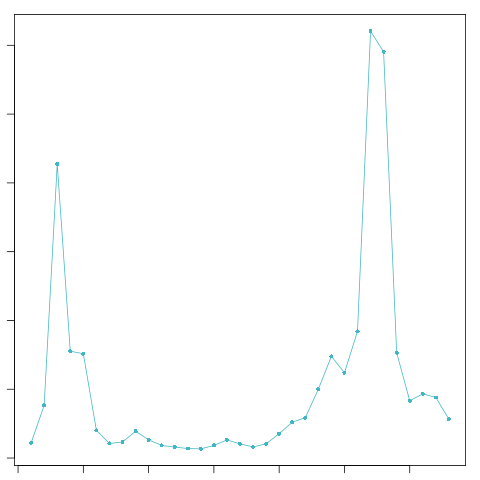

doublets_annotated/GSM3501447_cell_lines-ch_DOUBLETS.h5ad


  0%|          | 0/10 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█| 400/400 [01:28<00:00,  4.55it/s, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [01:28<00:00,  4.51it/s, v_num=1, train_loss_step
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 251/400:  63%|▋| 251/400 [00:44<00:26,  5.67it/s, v_num=1, train_loss_step
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.343. Signaling Trainer to stop.


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8255
Number of edges: 268143

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 15
Elapsed time: 0 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."


Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  RPS4Y1, GMFG, AIF1, S100A4, LST1, CLEC11A, ARHGDIB, CA2, EIF1AY, TMSB4X 
	   PLAC8, IGFBP7, PSMB8, PYCARD, NUCB2, ALOX5AP, CTSG, SRGN, CAPG, CD74 
	   TYROBP, AZU1, LGALS1, ELANE, FCER1G, PRTN3, HLA-DR

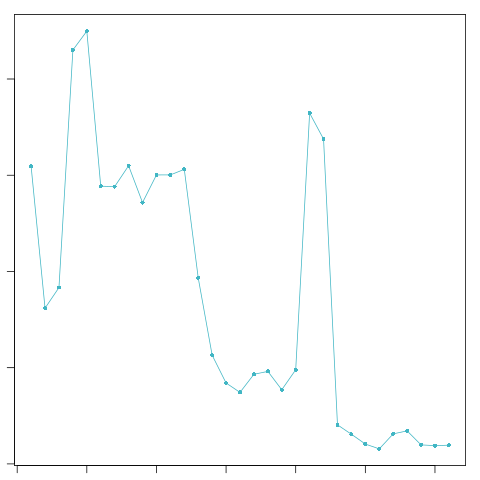

In [11]:
for path in paths:
    samp = path.replace('GSE266469_nasal/','').replace('.h5ad', '')
    save = 'doublets_annotated/' + samp + '_DOUBLETS.h5ad'
    print(save)

    if not os.path.exists(save):
        adata = sc.read_h5ad(path)
        adata = do_it(adata)
        adata.write_h5ad(save)